# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# Define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = data['filenames']
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# Load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# Print statistics about the dataset
print(f'There are {len(dog_names)} total dog categories.')
print(f'There are {len(train_files) + len(valid_files) + len(test_files)} total dog images.')
print(f'There are {len(train_files)} training dog images.')
print(f'There are {len(valid_files)} validation dog images.')
print(f'There are {len(test_files)} test dog images.')

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# Load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# Print statistics about the human dataset
print(f'There are {len(human_files)} total human images.')

There are 13233 total human images.


### Visualzie training data

In the cells below, we do an analysis of the class distribution of the training data.

In [41]:
train_targets_argmax = []
for i in range(len(train_targets)):
    train_targets_argmax.append(train_targets[i].argmax())
train_targets_argmax[:10]

[94, 56, 87, 7, 7, 62, 53, 118, 8, 80]

In [40]:
#train_targets
dog_names_str = []
for name in dog_names:
    dog_names_str.append(name.split(".")[1])
dog_names_str[:10]

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog']

In [62]:
import pandas as pd
dog_name_distribution = []
for dog in train_targets_argmax:
    dog_name_distribution.append(dog_names_str[dog])
dog_name_distribution = pd.DataFrame(dog_name_distribution,columns=['breed'])
dist = dog_name_distribution['breed'].value_counts()
dist.head(10)

Alaskan_malamute                  77
Border_collie                     74
Basset_hound                      73
Dalmatian                         71
Basenji                           69
Bull_terrier                      69
Bullmastiff                       69
Cavalier_king_charles_spaniel     67
American_staffordshire_terrier    66
Irish_terrier                     66
Name: breed, dtype: int64

In [127]:
df_dist = pd.DataFrame(dist).reset_index()
df_dist = df_dist.sort_values('breed', ascending=False)
df_dist.head()
df_dist['name'] = df_dist['index']
df_dist.drop('index',axis=1).head(10)

,breed,name
0,77,Alaskan_malamute
1,74,Border_collie
2,73,Basset_hound
3,71,Dalmatian
4,69,Basenji
5,69,Bull_terrier
6,69,Bullmastiff
7,67,Cavalier_king_charles_spaniel
10,66,Australian_shepherd
11,66,Australian_cattle_dog


Text(0,1,'Distribution of different dog breeds in the training data')

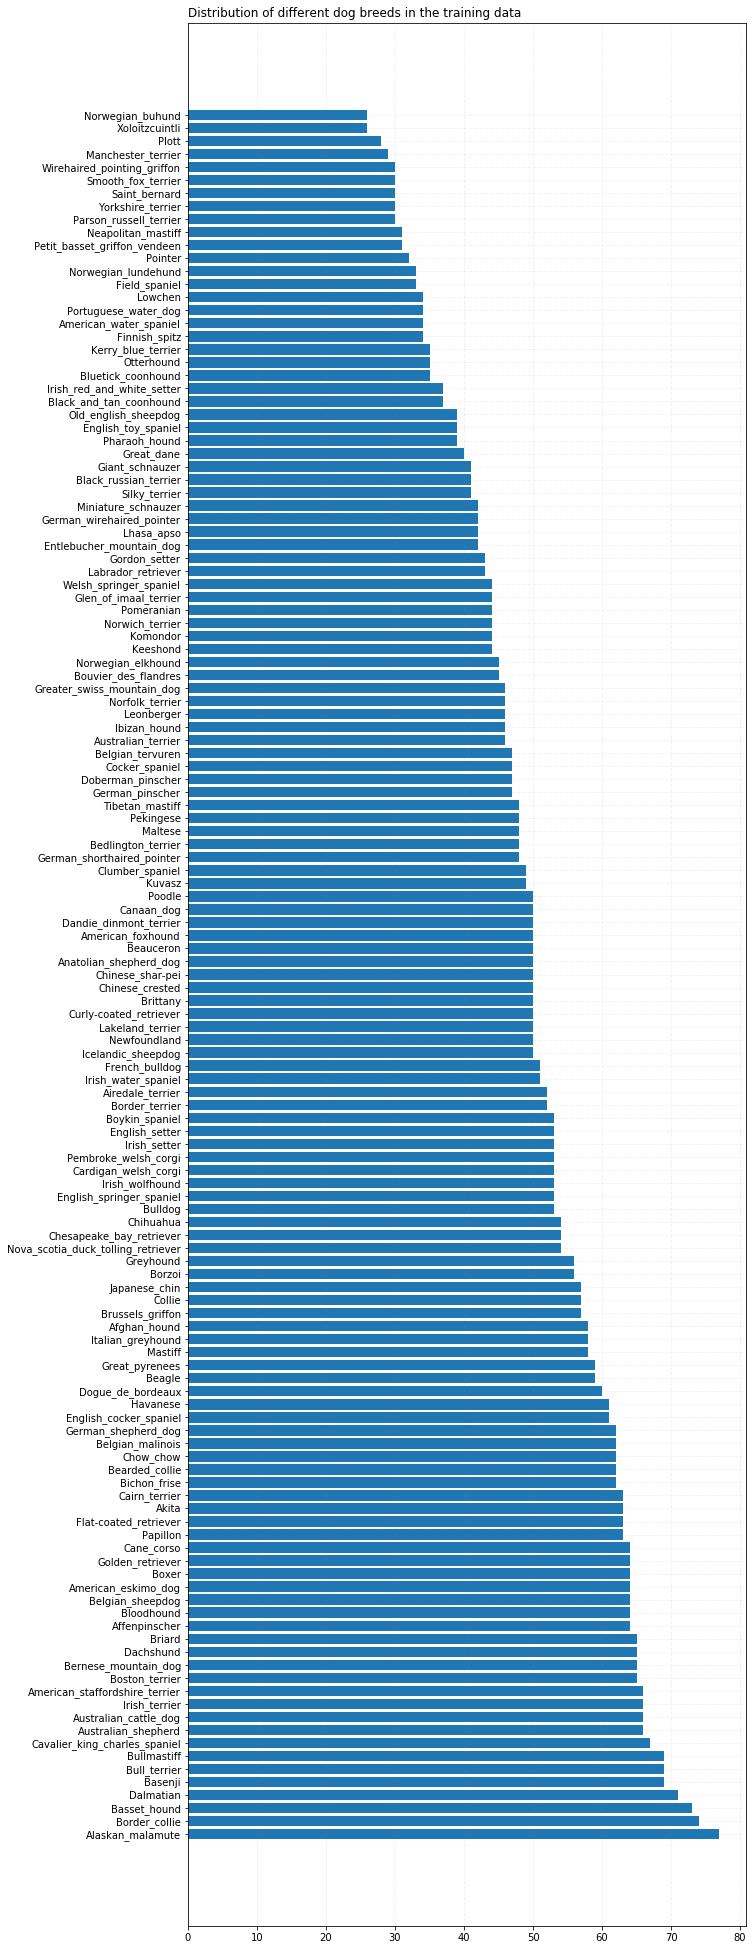

In [125]:
x = df_dist['index']
y = df_dist['breed']
fig, ax = plt.subplots(figsize =(10,35))
plt.barh(list(df_dist.index),y)
plt.yticks(range(len(y)),x)
ax.grid(b = True, color ='grey',
                linestyle ='-.', linewidth = 0.5,
                alpha = 0.2)
ax.set_title('Distribution of different dog breeds in the training data',
                    loc ='left', )

As we can see, there is a slight imbalance in the training data between breeds. Using accuracy should still be suitable as a metric, because of the large amount of target labels.

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


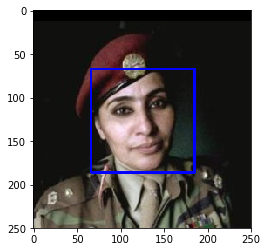

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- What percentage of the first 100 images in `human_files` have a detected human face? 
<br>100% of the first 100 images in human_files have a detected human face
- What percentage of the first 100 images in `dog_files` have a detected human face? 
<br>11% of the first 100 images in dog_files have a detected human face

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
is_human_human = [face_detector(img) for img in human_files_short]
perc_human_human = 100 * np.mean(is_human_human)
print("{:.0f}% of the first 100 images in human_files have a detected human face"
          .format(perc_human_human))

is_dog_human = [face_detector(img) for img in dog_files_short]
perc_dog_human = 100 * np.mean(is_dog_human)
print("{:.0f}% of the first 100 images in dog_files have a detected human face"
          .format(perc_dog_human))

100% of the first 100 images in human_files have a detected human face
11% of the first 100 images in dog_files have a detected human face


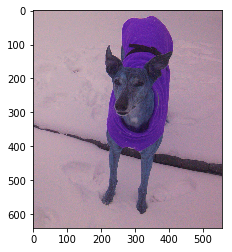

In [6]:
img_path = dog_files_short[9]
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

In my opinion, asking for such prerequisite is completely fine. Personally I wouldn't be offended by the result of the model, if I know I didn't meet the prerequisite it asked for. Some improvements could be to have a minimum resolution criteria on images, or to detect if an image is too dark, and adjust it accordingly during preprocessing.
<br>
<br>

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        # Normalize the image tensor
        #return np.expand_dims(x, axis=0)
        return np.expand_dims(x, axis=0)
    except IOError:
        print(f"Warning: Skipping corrupted image {img_path}")
        return None

def paths_to_tensor(img_paths):
    batch_tensors = []
    for img_path in img_paths:
        tensor = path_to_tensor(img_path).astype('float32')/255
        if tensor is not None:
            batch_tensors.append(tensor[0])
    return np.array(batch_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [12]:
def dog_detector2(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return prediction

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- What percentage of the images in `human_files_short` have a detected dog?  
0% of the first 100 images in human_files have a detected dog
- What percentage of the images in `dog_files_short` have a detected dog?
<br>100% of the first 100 images in dog_files have a detected dog

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
is_human_dog = [dog_detector(img) for img in human_files_short]
perc_human_human = 100 * np.mean(is_human_dog)
print("{:.0f}% of the first 100 images in human_files have a detected dog"
          .format(perc_human_human))

is_dog_dog = [dog_detector(img) for img in dog_files_short]
perc_dog_human = 100 * np.mean(is_dog_dog)
print("{:.0f}% of the first 100 images in dog_files have a detected dog"
          .format(perc_dog_human))

0% of the first 100 images in human_files have a detected dog
100% of the first 100 images in dog_files have a detected dog


In [14]:
img_path = dog_files_short[0]
dog_detector2(img_path)

222

In [15]:
img_path = dog_files_short[1]
img = preprocess_input(path_to_tensor(img_path))
np.argmax(ResNet50_model.predict(img))

251

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading of truncated images

def image_generator(files, targets, batch_size):
    while True:
        batch_paths = np.random.choice(a=files, size=batch_size)
        batch_input = paths_to_tensor(batch_paths)
        valid_paths = [p for p in batch_paths if path_to_tensor(p) is not None]
        batch_indices = [np.where(files == img_path)[0][0] for img_path in valid_paths]
        batch_output = np.array([targets[index] for index in batch_indices])

        if len(batch_input) > 0:  # Ensure there is data to yield
            yield batch_input, batch_output

# Create generators for train, validation, and test datasets
train_generator = image_generator(train_files, train_targets, batch_size=64)
valid_generator = image_generator(valid_files, valid_targets, batch_size=64)
test_generator = image_generator(test_files, test_targets, batch_size=64)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
<br>I took several points into consideration while designing the architecture:
 - Convolutional layers (Conv2D), should be paired together with Pooling layers (Maxpool2D)
 - These paired layers should be stacked behind eachother, the number of these layer-pairs is determined by testing
 - Each convolutional layer uses a (2,2) sized kernel, 'relu' activation function, and its filter size doubles with each layer-pair. The initial filter-size is also selected by testing (checking powers of 2).
 - At the end of the network, I use a Flattening and one Dense layer (with 'softmax' activation function), with the units of the dense layer being the number of classes to be predicted (133 in this case).
 
After these, I experimented with the number of conv-pooling layer pairs, and the filter-size of the convolutional layers. The final values were:
 - number of layer pairs: 3
 - initial filter size: 8

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

kernel_size = (2,2)
filter_size = 8
padding = 'same'

### TODO: Define your architecture.
model = Sequential()
model.add(Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=filter_size*2, kernel_size=kernel_size, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=filter_size*4, kernel_size=kernel_size, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 8)       104       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 16)      528       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
__________

### Compile the Model

In [26]:
from keras.optimizers import Adam

# Set a smaller learning rate
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

# Add checkpoint to save the best model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)

# ReduceLROnPlateau: This callback reduces the learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_files) // 32,
                    validation_data=valid_generator,
                    validation_steps=len(valid_files) // 32,
                    epochs=epochs,
                    callbacks=[checkpointer, reduce_lr],
                    verbose=2)

Epoch 1/10
Epoch 00001: val_loss improved from inf to 4.87376, saving model to saved_models/weights.best.from_scratch.hdf5
 - 382s - loss: 3.7001 - acc: 0.2595 - val_loss: 4.8738 - val_acc: 0.0769
Epoch 2/10
Epoch 00002: val_loss did not improve
 - 371s - loss: 1.0482 - acc: 0.8017 - val_loss: 6.3225 - val_acc: 0.0631
Epoch 3/10
Epoch 00003: val_loss did not improve
 - 361s - loss: 0.2311 - acc: 0.9598 - val_loss: 7.2444 - val_acc: 0.0691
Epoch 4/10
Epoch 00004: val_loss did not improve
 - 364s - loss: 0.0580 - acc: 0.9926 - val_loss: 7.3660 - val_acc: 0.0739
Epoch 5/10
Epoch 00005: val_loss did not improve
 - 358s - loss: 0.0335 - acc: 0.9972 - val_loss: 7.6885 - val_acc: 0.0847
Epoch 6/10
Epoch 00006: val_loss did not improve
 - 343s - loss: 0.0304 - acc: 0.9979 - val_loss: 8.0957 - val_acc: 0.0769
Epoch 7/10
Epoch 00007: val_loss did not improve
 - 368s - loss: 0.0277 - acc: 0.9981 - val_loss: 8.0074 - val_acc: 0.0619
Epoch 8/10
Epoch 00008: val_loss did not improve
 - 365s - loss: 

### Load the Model with the Best Validation Loss

In [28]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [29]:
# Evaluate the model on the test data using `evaluate_generator`
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_files) // 32)

# Convert the accuracy to percentage
test_accuracy = test_accuracy * 100

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.1298%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [30]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [31]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [32]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 484us/step - loss: 12.1272 - acc: 0.1153 - val_loss: 10.4018 - val_acc: 0.2060
Epoch 2/20
6680/6680 [==============================] - 3s 418us/step - loss: 9.8311 - acc: 0.2813 - val_loss: 9.8540 - val_acc: 0.2802
Epoch 3/20
6680/6680 [==============================] - 3s 428us/step - loss: 9.3819 - acc: 0.3476 - val_loss: 9.7252 - val_acc: 0.3042
Epoch 4/20
6680/6680 [==============================] - 3s 425us/step - loss: 9.1355 - acc: 0.3760 - val_loss: 9.5442 - val_acc: 0.3090
Epoch 5/20
6680/6680 [==============================] - 3s 428us/step - loss: 8.8962 - acc: 0.4013 - val_loss: 9.3848 - val_acc: 0.3425
Epoch 6/20
6680/6680 [==============================] - 3s 425us/step - loss: 8.7998 - acc: 0.4213 - val_loss: 9.3546 - val_acc: 0.3329
Epoch 7/20
6680/6680 [==============================] - 3s 446us/step - loss: 8.4968 - acc: 0.4373 - val_loss: 9.0398 - val_acc: 0.3641

### Load the Model with the Best Validation Loss

In [34]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [35]:
# Test the model
test_predictions = VGG16_model.predict(test_VGG16, batch_size=20)
test_accuracy = 100 * np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_targets, axis=1))
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.3014%


### Predict Dog Breed with the Model

In [37]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [40]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
<br>For the transfer-learning approach, I used a simpler architecture, than the one I used when building from scratch. The architecture is similar to the one from the previous step. I started out with a known architecture, and intended to tweak it as needed, but since the test-accuracy is 81.22%, I deemed further optimization not needed.

In [41]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape = train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [42]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [43]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 489us/step - loss: 1.6285 - acc: 0.5966 - val_loss: 0.7738 - val_acc: 0.7677
Epoch 2/20
6680/6680 [==============================] - 3s 415us/step - loss: 0.4399 - acc: 0.8659 - val_loss: 0.7181 - val_acc: 0.7844
Epoch 3/20
6680/6680 [==============================] - 3s 408us/step - loss: 0.2578 - acc: 0.9171 - val_loss: 0.7213 - val_acc: 0.7808
Epoch 4/20
6680/6680 [==============================] - 3s 411us/step - loss: 0.1803 - acc: 0.9430 - val_loss: 0.6152 - val_acc: 0.8204
Epoch 5/20
6680/6680 [==============================] - 3s 412us/step - loss: 0.1262 - acc: 0.9623 - val_loss: 0.6674 - val_acc: 0.8120
Epoch 6/20
6680/6680 [==============================] - 3s 404us/step - loss: 0.0897 - acc: 0.9719 - val_loss: 0.6954 - val_acc: 0.8096
Epoch 7/20
6680/6680 [==============================] - 3s 405us/step - loss: 0.0638 - acc: 0.9807 - val_loss: 0.6760 - val_acc: 0.8168
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [44]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [45]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2201%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [46]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [56]:
# test the Resnet50 model
img_path = dog_files_short[6]
dog_str = Resnet50_predict_breed(img_path)
dog_name = dog_str.split(".")
dog_name = dog_name[1]
print(dog_name)

Collie


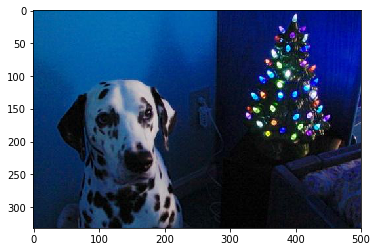

In [59]:
img = cv2.imread(img_path)
plt.imshow(img)

### Show and compare the results using different models, parameters, or techniques
There were 3 approaches tested, the results are summarized in the following section.

<Container object of 3 artists>

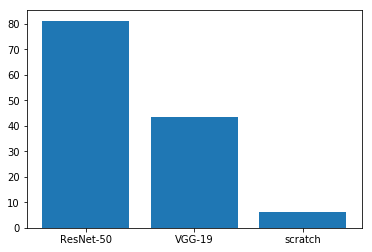

In [132]:
results = pd.DataFrame({
        'model':  ['scratch', 'VGG-19', 'ResNet-50'],
        'accuracy': [6.1298, 43.3014, 81.2201]
})
plt.bar(results.model,results.accuracy)

As we can see, the ResNet-50 model produces by far the best results. The models using transfer learning (ResNet-50 and VGG-19) also have significantly shorter training time. (about 1:100-120).

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [170]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def display_result(dog_name):
    plt.imshow(cv2.imread(img_path))
    

def predict_breed(img_path):    
    if dog_detector(img_path):
        dog_str = Resnet50_predict_breed(img_path)
        dog_name = dog_str.split(".")[1]
        display_result(dog_name)
        print('This is a {}!'.format(dog_name))
    elif face_detector(img_path):
        dog_str = Resnet50_predict_breed(img_path)
        dog_name = dog_str.split(".")[1]
        display_result(dog_name)
        print('This photo looks like a {}.'.format(dog_name))
    else:
        display_result(img_path)
        print("The image doesn't seem neither dog nor human!")

This is a Welsh_springer_spaniel!


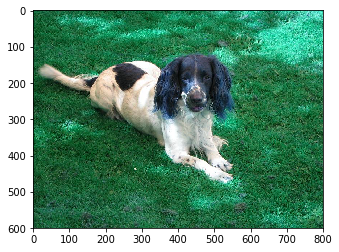

In [158]:
img_path = dog_files_short[5]
predict_breed(img_path)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

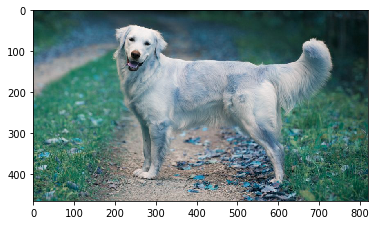

In [137]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import os

img_path = '/images/upload/img_2.jpg'
path = os.getcwd() + img_path
img = cv2.imread(path)
plt.imshow(img)

In [171]:
from os import listdir
from os.path import isfile, join

file_path = '/images/upload'
dir_path = os.getcwd() + file_path
img_names = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

img_paths = []
for curr_img in img_names:
    img_path = dir_path + '/' + curr_img
    img_paths.append(img_path)
print(img_paths)

['/workspace/home/dog-project/images/upload/img_2.jpg', '/workspace/home/dog-project/images/upload/img_4.jpg', '/workspace/home/dog-project/images/upload/img_1.jpg', '/workspace/home/dog-project/images/upload/img_5.jpg', '/workspace/home/dog-project/images/upload/img_3.jpg', '/workspace/home/dog-project/images/upload/img_6.jpg']


This is a Golden_retriever!


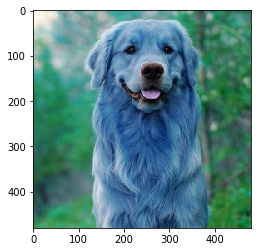

In [172]:
img_path = img_paths[0]
predict_breed(img_path)

The image doesn't seem either dog or human!


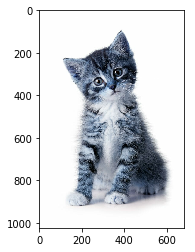

In [165]:
img_path = img_paths[1]
predict_breed(img_path)

This photo looks like a Dogue_de_bordeaux


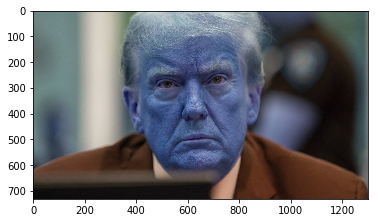

In [173]:
img_path = img_paths[2]
predict_breed(img_path)

This photo looks like a Silky_terrier


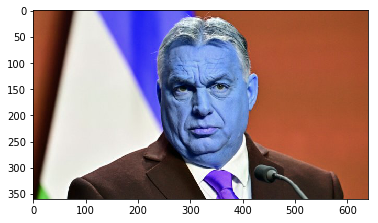

In [174]:
img_path = img_paths[3]
predict_breed(img_path)

This is a Pembroke_welsh_corgi!


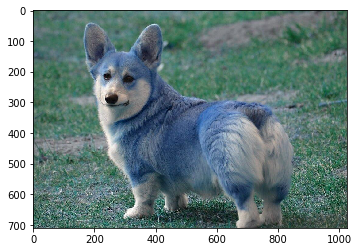

In [168]:
img_path = img_paths[4]
predict_breed(img_path)

The image doesn't seem either dog or human!


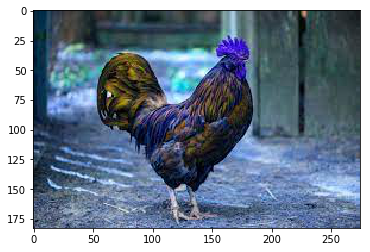

In [169]:
img_path = img_paths[5]
predict_breed(img_path)

## Reflection
I really enjoyed working with CNNs. Personally, it adds a layer of engagement if the data is already visual. This of course brings a couple challenges as well, sometimes (as explained in the Step 3 instructions) it's not so easy to judge if a decision satisfactory because of this.